# COX Proportional Hazards Model for IAA-first Outcome  
>
This notebook contains the code for generating supplementary figures 7 and 8.  

For the main analysis, tri-SNP dosage (0, 1 or 2) is fitted along with covariates: sex, having a first degree relative with T1D diagnosis, genetic ancestry, HLA type, country and SNPS previously associated with the outcome.

The analyses are repeated using only DR3/DQ2 homozygotes.

This notebook is not heavily commented. Please see the code notebook for supplementary figures 1 and 2 for the comments and detailed explanation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from lifelines import CoxPHFitter
import pickle
import warnings
warnings.filterwarnings("ignore")
import session_info

session_info.show(html=False)

-----
lifelines           0.26.3
matplotlib          3.9.4
pandas              1.5.3
session_info        1.0.0
-----
IPython             8.18.1
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.5
notebook            7.4.5
-----
Python 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:27:35) [Clang 11.1.0 ]
macOS-15.6.1-x86_64-i386-64bit
-----
Session information updated at 2025-09-19 10:07


Import metadata

In [2]:
filtered = pd.read_csv("../data/filtered_meta_final.csv")
filtered.head()

,mp257_maskid,family_id,immunochip_id,sex,Cntry,POP,ancestry,POP_reported,t1d,t1d_diag_age_censor,...,rs61751041 (LAMB1),rs6967298 (AUTS2),rs72704176 (ASH1L),rs72717025 (FCGR2A),rs73043122 (RNASET2/MIR3939),rs77532435 (GRB10),rs8013918 (FOS),rs9934817 (RBFOX1),rs389884,rs926552
0,996512,9000247.0,9000247_996512,Male,SWE,EUR,EUR,NaN,1,135.972,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,474979,474979.0,474979_474979,Male,SWE,EUR,EUR,NaN,0,183.443,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,581412,581412.0,581412_581412,Male,SWE,EUR,EUR,NaN,0,186.235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,864158,864158.0,864158_864158,Male,SWE,EUR,EUR,EUR,0,167.017,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,669152,669152.0,669152_669152,Male,SWE,EUR,EUR,NaN,0,174.080,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0


Create ordered hla type list

In [3]:
select_hla = ['DR4/DR8', 'DR3/DR3', 'DR3/DR4',
              'DR4/DR4', "DR1/DR4", "DR4/DR13"]
filtered["hla_type"] = pd.Categorical(filtered["hla_type"], 
               categories=select_hla,
               ordered=True)

Create oredered population list

In [4]:
select_pops = ["EUR", "AMR", "AFR"]
filtered["POP"] = pd.Categorical(
    filtered["POP"],
    categories=select_pops,
    ordered=True)

Create ordered country category

In [5]:
ctry = ["US", "SWE", "FIN", "GER"]
filtered["Country"] = pd.Categorical(
    filtered["Cntry"],
    categories=ctry,
    ordered=True)

Load previous GWAS covariates

In [6]:
snps = pd.read_table("../data/assoc_snps_220824.tsv")
snps.head()

,SNP,Locus,CD_SNP,tTGA_SNP,T1D_SNP,IAA_SNP,SNP_locus
0,rs4851575,"IL18R1, IL18RAP",1,0,0,0,"rs4851575 (IL18R1, IL18RAP)"
1,rs114569351,"PLEK,FBXO48",1,0,0,0,"rs114569351 (PLEK,FBXO48)"
2,rs12493471,"CCR9,LZTFL1,CXCR6",1,0,0,0,"rs12493471 (CCR9,LZTFL1,CXCR6)"
3,rs1054091,"RSPH3,TAGAP",1,0,0,0,"rs1054091 (RSPH3,TAGAP)"
4,rs72704176,ASH1L,1,0,0,0,rs72704176 (ASH1L)


In [7]:
t1d_snps = list(snps.loc[snps["T1D_SNP"] == 1, "SNP_locus"].values)
iaa_snps = list(snps.loc[snps["IAA_SNP"] == 1, "SNP_locus"].values)
tga_snps = list(snps.loc[snps["tTGA_SNP"] == 1, "SNP_locus"].values)
cd_snps = list(snps.loc[snps["CD_SNP"] == 1, "SNP_locus"].values)

## Run coxph model for IAA-first outcome

In [8]:
assoc = iaa_snps
event = "Event = First Autoantibody IAA"
common_variables = ['sex', 'FDR-T1D', 'POP', "hla_type", 
                    "Country"] + assoc


common_others = ["Male", 'FDR-T1D']

time, outcome = "IAA_censor", "IAA first"
outcomes = [time, outcome]

### Fit trisnp
This creates supplementary figure 7

<lifelines.CoxPHFitter: fitted with 7614 total observations, 7301 right-censored observations>
             duration col = 'IAA_censor'
                event col = 'IAA first'
          robust variance = True
      baseline estimation = breslow
   number of observations = 7614
number of events observed = 313
   partial log-likelihood = -2655.53
         time fit was run = 2025-09-19 14:07:19 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
tri-SNP 101            -0.45       0.64       0.18            -0.80            -0.10                 0.45                 0.91
FDR-T1D                 0.88       2.40       0.16             0.57             1.19                 1.76                 3.28
rs428595 (PPIL2)        0.50       1.64       0.20             0.10             0.89                 1.11                 2.44
rs1004446 (INS)        -0.24       0.78       0.09            -0.42            -0.07                 0.66                 0.93
rs2476601 (PTPN22)      0.33       1.39       0.11             0.12             0.54                 1.13                 1.72
rs2292239 (ERBB3)       0.14       1.15       0.08            -0.01             0.30                 0.99                 1.35
rs3184504 (SH2B3)       0.23       1.25       0.08             0.06             0.39                 1.06                 1.48
rs9934817 (RBFOX1)      0.04       1.04       0.30            -0.56             0.63                 0.57                 1.89
rs11705721 (PXK/PDHB)   0.24       1.27       0.08             0.08             0.40                 1.08                 1.48
Male                    0.19       1.21       0.11            -0.03             0.42                 0.97                 1.52
AMR                    -0.20       0.82       0.25            -0.70             0.30                 0.50                 1.35
AFR                    -0.62       0.54       0.99            -2.55             1.31                 0.08                 3.71
DR3/DR3                -0.17       0.84       0.38            -0.92             0.58                 0.40                 1.78
DR3/DR4                 0.43       1.54       0.22             0.01             0.86                 1.01                 2.36
DR4/DR4                -0.20       0.82       0.19            -0.56             0.17                 0.57                 1.19
DR1/DR4                -0.62       0.54       0.39            -1.38             0.14                 0.25                 1.15
DR4/DR13               -0.06       0.94       0.48            -0.99             0.87                 0.37                 2.40
SWE                     0.19       1.21       0.15            -0.10             0.48                 0.90                 1.61
FIN                     0.57       1.76       0.15             0.26             0.87                 1.30                 2.38
GER                    -0.09       0.91       0.26            -0.59             0.41                 0.55                 1.51

                          z      p   -log2(p)
covariate                                    
tri-SNP 101           -2.51   0.01       6.36
FDR-T1D                5.56 <0.005      25.13
rs428595 (PPIL2)       2.47   0.01       6.20
rs1004446 (INS)       -2.79   0.01       7.57
rs2476601 (PTPN22)     3.10 <0.005       9.02
rs2292239 (ERBB3)      1.82   0.07       3.86
rs3184504 (SH2B3)      2.66   0.01       7.02
rs9934817 (RBFOX1)     0.12   0.90       0.15
rs11705721 (PXK/PDHB)  2.88 <0.005       7.98
Male                   1.70   0.09       3.49
AMR                   -0.79   0.43       1.22
AFR                   -0.63   0.53       0.92
DR3/DR3               -0.45   0.65       0.62
DR3/DR4                1.99   0.05       4.43
DR4/DR4               -1.05   0.29       1.77
DR1/DR4            

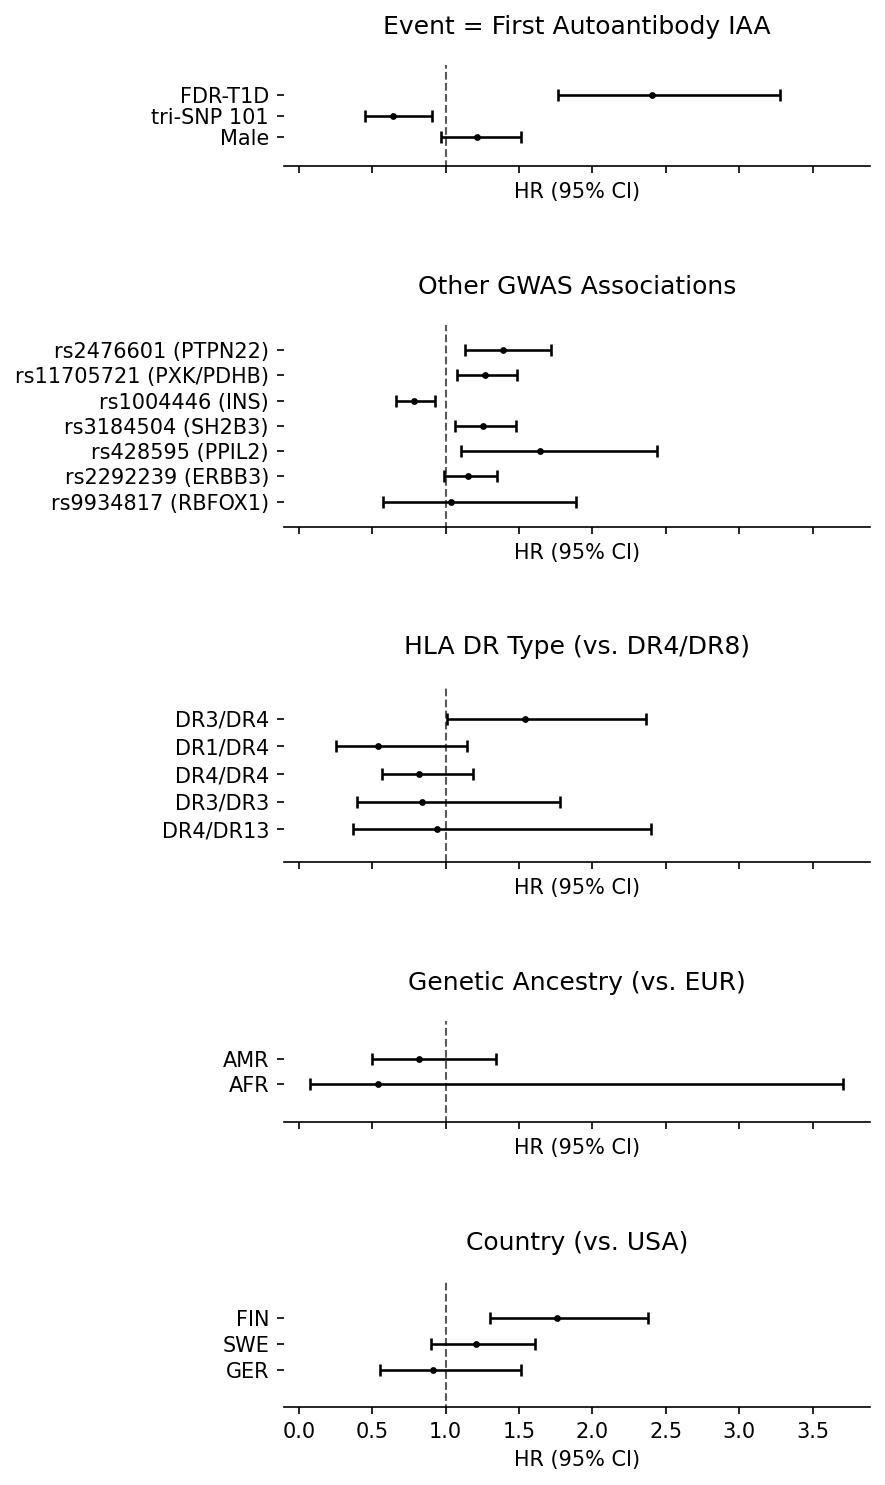

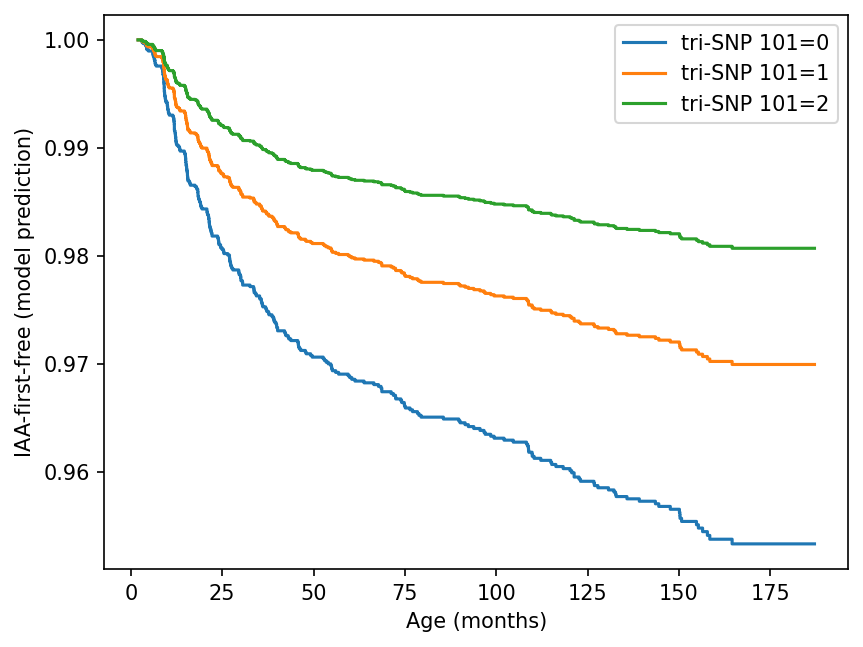

In [9]:
fit_var = "tri-SNP 101"

extension = "cox_iaa_all_samples"
ylabel = "IAA-first-free (model prediction)"

variables = [fit_var] + common_variables
data = filtered.loc[:, variables + outcomes].dropna()
dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_hla, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "HLA DR Type (vs. DR4/DR8)", 
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### DR3 homozygotes only
This creates supplementary figure 8.

In [10]:
# remove some of the SNPs to accommodate cox PH requirements
assoc = [s for s in iaa_snps if s not in ["rs428595 (PPIL2)"]]
event = "Event = First Autoantibody IAA, DR3 Only"

common_variables = ['sex', 'FDR-T1D', "POP",
                    "Country"] + assoc

### Fit trisnp

<lifelines.CoxPHFitter: fitted with 1570 total observations, 1541 right-censored observations>
             duration col = 'IAA_censor'
                event col = 'IAA first'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1570
number of events observed = 29
   partial log-likelihood = -193.66
         time fit was run = 2025-09-19 14:07:25 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
tri-SNP 101            -0.73       0.48       0.33            -1.37            -0.09                 0.25                 0.91
FDR-T1D                 0.66       1.94       0.58            -0.47             1.80                 0.62                 6.06
rs1004446 (INS)        -0.35       0.71       0.29            -0.92             0.22                 0.40                 1.25
rs2476601 (PTPN22)     -0.24       0.78       0.55            -1.32             0.84                 0.27                 2.31
rs2292239 (ERBB3)       0.47       1.60       0.26            -0.05             0.98                 0.95                 2.67
rs3184504 (SH2B3)       0.38       1.47       0.28            -0.16             0.93                 0.85                 2.54
rs9934817 (RBFOX1)      0.18       1.20       1.03            -1.83             2.20                 0.16                 8.99
rs11705721 (PXK/PDHB)   0.37       1.45       0.25            -0.12             0.86                 0.89                 2.36
Male                   -0.57       0.56       0.39            -1.35             0.20                 0.26                 1.22
AMR                    -0.59       0.55       1.00            -2.55             1.36                 0.08                 3.90
SWE                     0.62       1.85       0.44            -0.25             1.48                 0.78                 4.40
FIN                     0.84       2.31       0.57            -0.28             1.96                 0.75                 7.09
GER                    -0.41       0.67       1.09            -2.54             1.73                 0.08                 5.62

                          z    p   -log2(p)
covariate                                  
tri-SNP 101           -2.24 0.03       5.31
FDR-T1D                1.15 0.25       1.99
rs1004446 (INS)       -1.20 0.23       2.11
rs2476601 (PTPN22)    -0.44 0.66       0.60
rs2292239 (ERBB3)      1.78 0.07       3.75
rs3184504 (SH2B3)      1.38 0.17       2.57
rs9934817 (RBFOX1)     0.18 0.86       0.22
rs11705721 (PXK/PDHB)  1.49 0.14       2.89
Male                  -1.46 0.15       2.78
AMR                   -0.60 0.55       0.86
SWE                    1.40 0.16       2.63
FIN                    1.46 0.14       2.80
GER                   -0.37 0.71       0.50
---
Concordance = 0.75
Partial AIC = 413.31
log-likelihood ratio test = 19.82 on 13 df
-log2(p) of ll-ratio test = 3.32

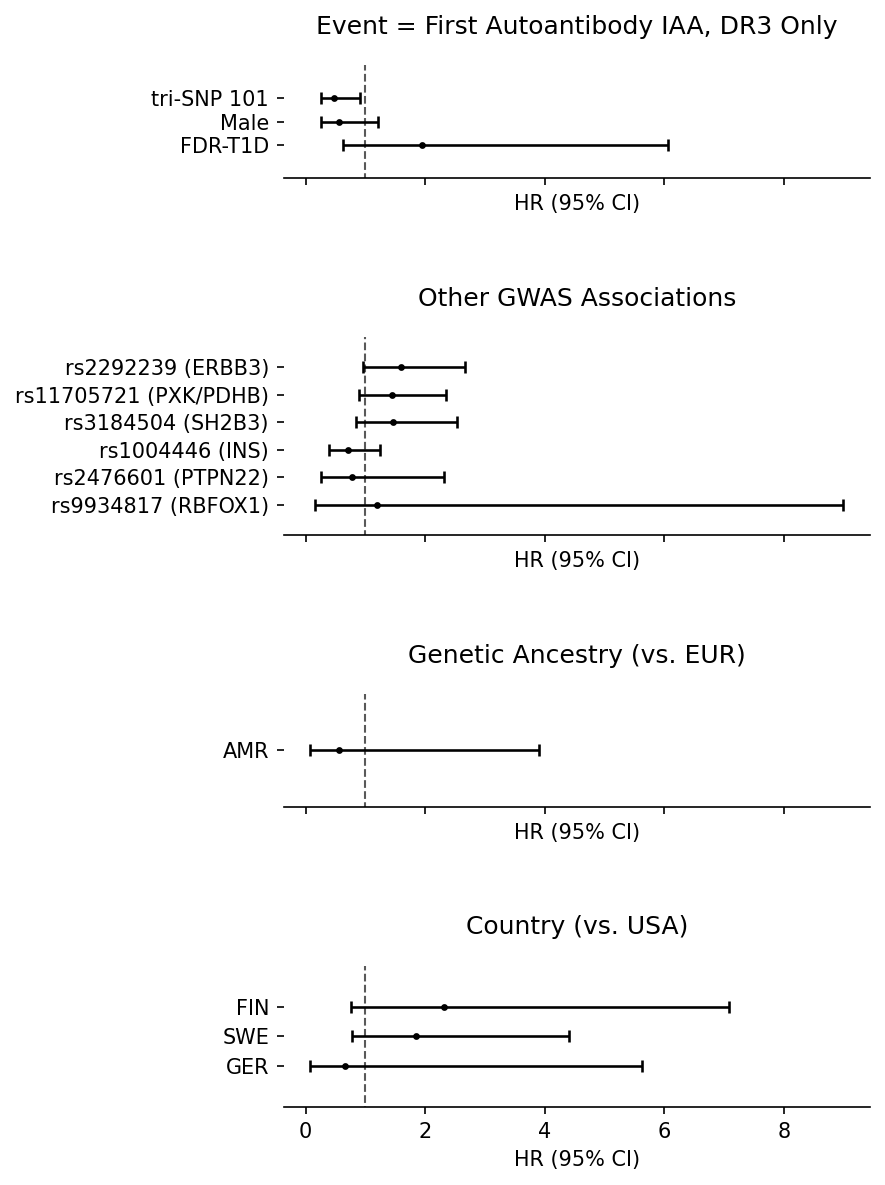

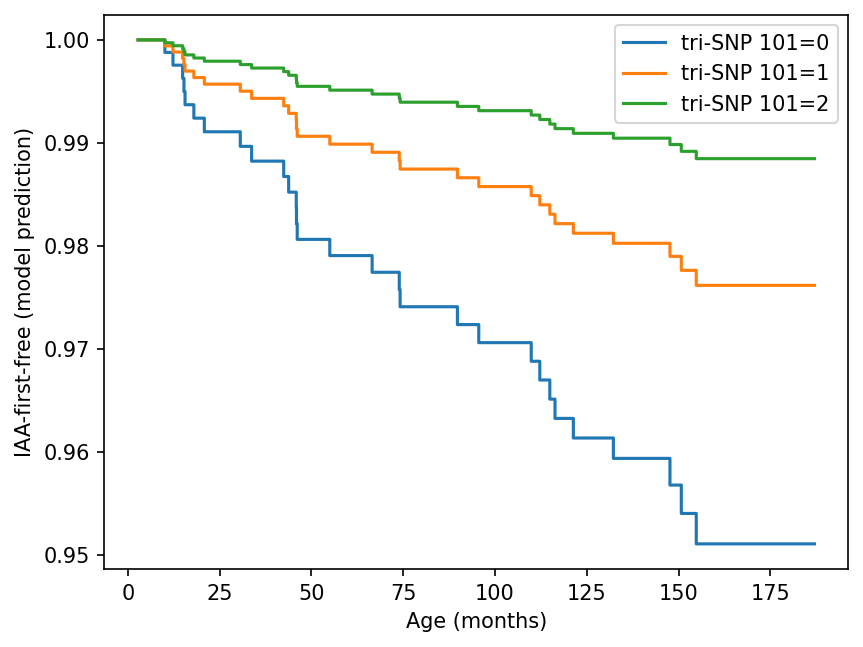

In [11]:
fit_var = "tri-SNP 101"

extension = "cox_iaa_dr3_samples"
ylabel = "IAA-first-free (model prediction)"

variables = [fit_var] + common_variables

data = filtered.loc[(filtered["hla_type"] == "DR3/DR3")
                    & (filtered["POP"] != "AFR"),
                    variables + outcomes].dropna()

dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="").drop("AFR", axis=1)
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=True, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)